In [1]:
import os
import requests
import numpy as np
import pandas as pd
from tqdm import tqdm
from datetime import date, datetime, timedelta
from bs4 import BeautifulSoup
import ast
import typing
import seaborn as sns
import matplotlib as plt
pd.set_option('display.max_columns', None)
from IPython.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

In [55]:
!pip install wget

  Preparing metadata (setup.py) ... done
  Created wheel for wget: filename=wget-3.2-py3-none-any.whl size=9657 sha256=1517d88f38d0c1bb14ccce682ad860f0e79bfd80b8718a7b0b063c6f9089a97f
  Stored in directory: /Users/maria/Library/Caches/pip/wheels/04/5f/3e/46cc37c5d698415694d83f607f833f83f0149e49b3af9d0f38
Successfully built wget


In [56]:
import warnings
warnings.filterwarnings('ignore')

In [57]:
months = ['Gener', 'Febrer', 'Marc', 'Abril', 'Maig', 'Juny', 'Juliol', 'Agost', 'Setembre', 'Octubre', 'Novembre', 'Desembre']

In [65]:
if not os.path.isdir("Traffic_Trams"):
    os.makedirs("Traffic_Trams")

if not len(os.listdir('./Traffic_Trams')):
    i2m = list(zip(range(1,13), months))
    os.chdir("Traffic_Trams")
    for year in [2023, 2022, 2021, 2020, 2019]:
        for month, month_name in i2m:        
            #os.system(f"wget 'https://opendata-ajuntament.barcelona.cat/resources/bcn/BicingBCN/{year}_{month:02d}_{month_name}_BicingNou_ESTACIONS.7z'")
            os.system(f"wget 'https://opendata-ajuntament.barcelona.cat/resources/bcn/trams/{year}_{month:02d}_{month_name}_TRAMS_TRAMS.csv'")
            #os.system(f"wget 'https://opendata-ajuntament.barcelona.cat/data/en/dataset/trams/resource/{year}_{month:02d}_{month_name}_TRAMS_TRAMS.csv'")
            #os.system(f"wget 'https://opendata-ajuntament.barcelona.cat/data/es/dataset/trams/{year}_{month:02d}_{month_name}_TRAMS_TRAMS.csv' ")
            #os.system(f"7z x '{year}_{month:02d}_{month_name}_BicingNou_ESTACIONS.7z'")
            #os.system(f"rm '{year}_{month:02d}_{month_name}_BicingNou_ESTACIONS.7z'")
    os.chdir("..")
    
https://opendata-ajuntament.barcelona.cat/data/dataset/8319c2b1-4c21-4962-9acd-6db4c5ff1148/resource/d3782748-9818-4d3d-a09e-4e8caecb341a/download


In [66]:
df = pd.DataFrame()

In [67]:
def get_datetime(miliseconds: int):
    return datetime.fromtimestamp(miliseconds)

def create_date_df(df: pd.DataFrame):
    df['date'] = pd.to_datetime(df['data'], format='%Y%m%d%H%M%S')
    
    df['month'] = df['date'].dt.month
    df['year'] = df['date'].dt.year
    df['hour'] = df['date'].dt.hour
    df['day'] = df['date'].dt.day
    
    return df

In [68]:
def create_date_time(row):
    return datetime(
        int(row['year']),
        int(row['month']),
        int(row['day']),
        int(row['hour'])
    )

In [69]:
def process_new_df(new_df: pd.DataFrame):
    # Unique values
    new_df = new_df.drop_duplicates()
    #new_df = new_df.dropna(subset=['last_reported', 'last_updated'], axis=0)
    #new_df = new_df.sort_values('last_reported', ascending=True)
    
    # Convert some categorical into numerical
    #new_df.status = np.where(new_df.status == 'IN_SERVICE', 1, 0)
    #new_df.is_charging_station = np.where(new_df.is_charging_station, 1, 0)
    
    # Create the dates from timestamp and group statistics
    new_df = create_date_df(new_df)
    new_df = new_df\
        .groupby(['idTram', 'year', 'month', 'day', 'hour'])\
        .mean(numeric_only=True)\
        .reset_index()
    
    # Creation of the dates
    new_df['date_time'] = new_df.apply(lambda row: create_date_time(row), axis=1)
    new_df['date'] = new_df.date_time.dt.date
    
    return new_df

In [70]:
for csv in tqdm(os.listdir('./Traffic_Trams')):
    new_df = pd.read_csv('./Traffic_Trams/' + csv)
    new_df = process_new_df(new_df)
    
    # Filter out incorrect dates
    year, month, *_ = csv.split('_')
    year, month = int(year), int(month)
    new_df = new_df[(new_df.year == year) & (new_df.month == month)]
    
    df = pd.concat(
        [df, new_df], 
        axis=0
    )

  8%|███▋                                        | 1/12 [00:12<02:20, 12.79s/it]


UnicodeDecodeError: 'utf-8' codec can't decode byte 0xb0 in position 37: invalid start byte

In [19]:
file_2 = "Traffic_Trams/2023_01_Gener_TRAMS_TRAMS.csv"
df_traffic_trams = pd.read_csv(file_2)
print(df_traffic_trams.shape)
print(df_traffic_trams['estatActual'].value_counts())
print(df_traffic_trams['estatPrevist'].value_counts())

print(df_traffic_trams['estatActual'].isnull().sum())
print(df_traffic_trams['estatPrevist'].isnull().sum())
df_traffic_trams

(4672556, 4)
0    1998147
2    1329335
1     992392
3     205243
4      68556
6      47300
5      31583
Name: estatActual, dtype: int64
0    2189229
2    1163534
1     898387
3     255063
4      82966
6      47300
5      36077
Name: estatPrevist, dtype: int64
0
0


,idTram,data,estatActual,estatPrevist
0,1,20230101000054,0,0
1,2,20230101000054,0,0
2,3,20230101000054,0,0
3,4,20230101000054,0,0
4,5,20230101000054,0,0
...,...,...,...,...
4672551,535,20230131235554,0,0
4672552,536,20230131235554,0,0
4672553,537,20230131235554,0,0
4672554,538,20230131235554,0,0


In [20]:
df_traffic_trams['data'] = pd.to_datetime(df_traffic_trams['data'], format='%Y%m%d%H%M%S')


In [21]:
df_traffic_trams['year'] = df_traffic_trams['data'].dt.year
df_traffic_trams['month'] = df_traffic_trams['data'].dt.month
df_traffic_trams['day'] = df_traffic_trams['data'].dt.day
df_traffic_trams['hour'] = df_traffic_trams['data'].dt.hour

In [22]:
df_traffic_trams.sample(10)

,idTram,data,estatActual,estatPrevist,year,month,day,hour
3390515,80,2023-01-23 05:35:54,0,0,2023,1,23,5
1601954,103,2023-01-11 11:35:54,1,1,2023,1,11,11
4018343,148,2023-01-27 17:30:52,2,0,2023,1,27,17
2174666,383,2023-01-15 06:05:54,0,0,2023,1,15,6
1759362,39,2023-01-12 12:15:52,0,0,2023,1,12,12
3889595,144,2023-01-26 21:20:52,2,2,2023,1,26,21
2407902,71,2023-01-16 18:40:53,2,2,2023,1,16,18
2509585,142,2023-01-17 10:35:53,4,3,2023,1,17,10
2148339,124,2023-01-15 02:00:53,0,0,2023,1,15,2
1039856,329,2023-01-07 18:55:54,2,2,2023,1,7,18


In [36]:
loc_estat_actual = df_traffic_trams.loc[:, ['estatActual', 'hour']]
piv_estat_actual = pd.pivot_table(loc_estat_actual, values='estatActual', index=['hour'], aggfunc=np.sum)


<AxesSubplot:xlabel='hour', ylabel='estatActual'>

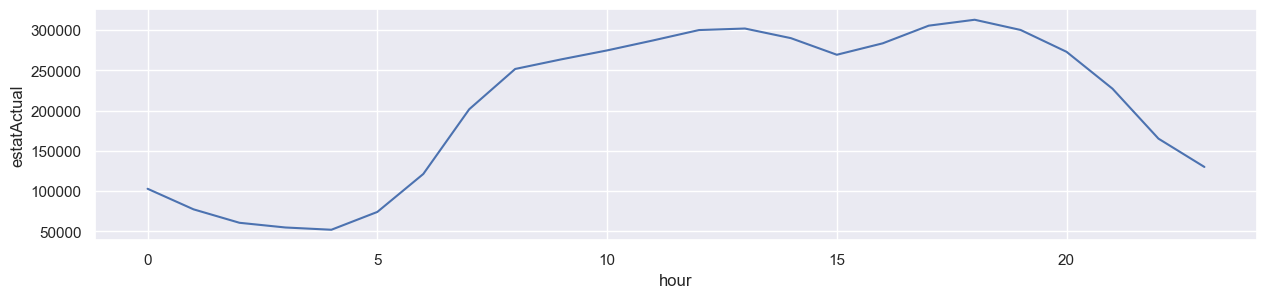

In [33]:
sns.set(rc={'figure.figsize':(15,3)})
sns.lineplot(data=piv_estat_actual, x="hour", y="estatActual")


In [35]:
print(df_traffic_trams['estatActual'].dtype)
df_traffic_trams['estatActual'] = df_traffic_trams['estatActual'].apply(str)
print(df_traffic_trams['estatActual'].dtype)

int64
object


In [45]:
group_estat_actual = df_traffic_trams.groupby(['hour', 'estatActual']).size().to_frame('count').reset_index()
group_estat_actual

,hour,estatActual,count
0,0,0,116188
1,0,1,58370
2,0,2,12955
3,0,3,1365
4,0,4,434
...,...,...,...
163,23,2,18108
164,23,3,1557
165,23,4,533
166,23,5,458


<AxesSubplot:xlabel='hour', ylabel='count'>

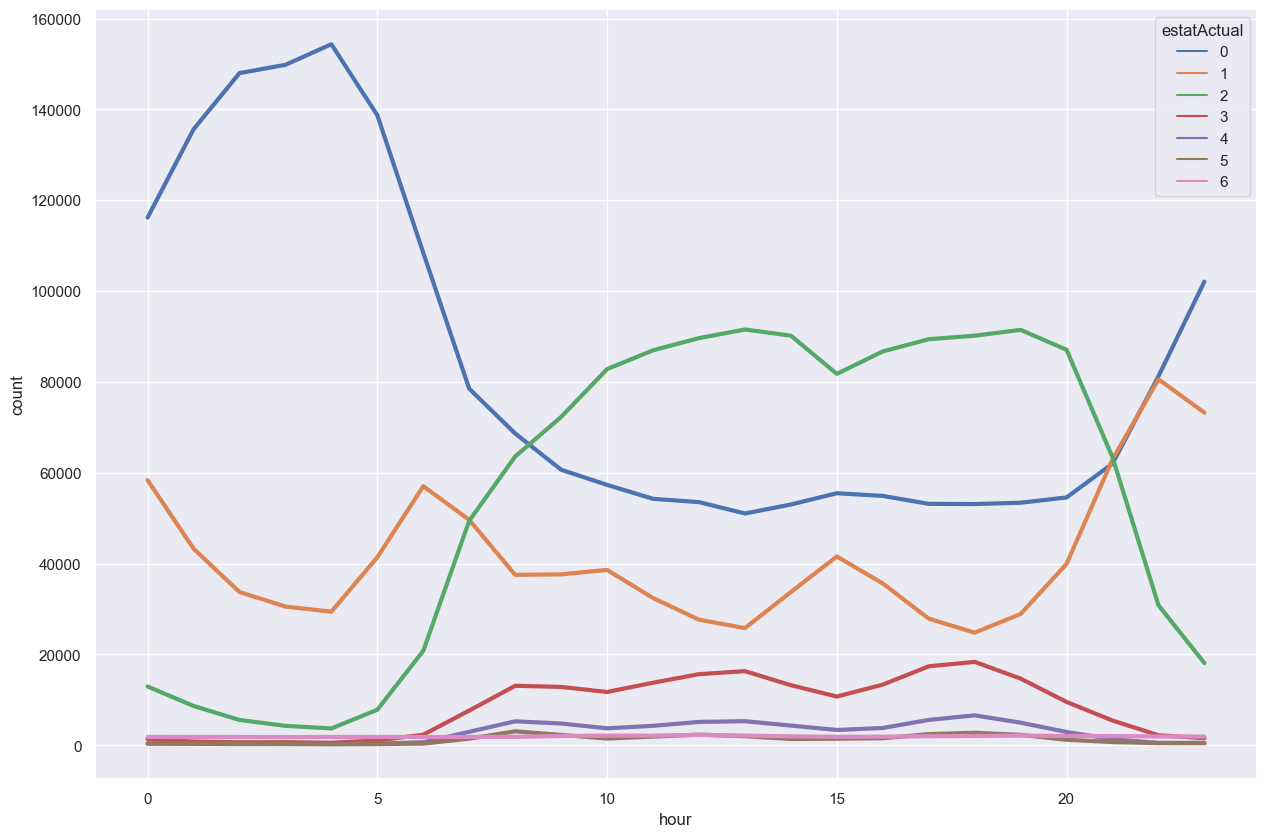

In [53]:
sns.set(rc={'figure.figsize':(15,10)})
sns.lineplot(x="hour", y="count",
             hue="estatActual",
             data=group_estat_actual, linewidth=3)

In [6]:
file_3 = "Traffic_Trams/transit_relacio_trams.csv"
df_relation_trams = pd.read_csv(file_3)

print(df_relation_trams.shape)
df_relation_trams.sample(10)

(527, 3)


,Tram,Descripció,Coordenades
162,163,Paral.lel (Entença a Pl. Espanya),"2.149722801000342,41.37508076792499,2.15399283..."
247,248,Còrsega (Passeig Maragall a Padilla),"2.174366639534286,41.40781904616355,2.18056173..."
83,84,República Argentina (Bolívar a Pl. Lesseps),"2.145624246063225,41.41081048840697,2.14594954..."
272,273,Aragó (Diagonal a Passeig de Sant Joan),"2.175969520947225,41.40049230921142,2.17210927..."
309,310,Deià (Piferrer a Passeig Verdum),"2.172232087822361,41.4355891722309,2.172656180..."
428,430,Av. Rio de Janeiro (Meridiana a Passeig de Val...,"2.186310476049722,41.44298619235413,2.18183698..."
3,4,Diagonal (Pl. Pius XII a Doctor Marañón),"2.122592049318304,41.38719094189204,2.11196902..."
94,95,Craywinckel - República Argentina (Balmes a Pl...,"2.13714034525369,41.41023559526721,2.137762082..."
255,256,Diagonal (Pl. Joan Carles I a Passeig de Sant ...,"2.159493237307972,41.39639250594108,2.16997011..."
234,235,Ronda Guinardó (Escorial a Túnel de la Rovira),"2.157622912155039,41.41117986190942,2.15875084..."


In [7]:
df_relation_trams = df_relation_trams.rename(columns={"Tram": 'idTram'})

In [8]:
df_trams = df_relation_trams.merge(df_traffic_trams, on='idTram')

In [9]:
print(df_traffic_trams.shape)
print(df_relation_trams.shape)
print(df_trams.shape)

(4672556, 8)
(527, 3)
(4628641, 10)


In [10]:
df_trams.sample(5)

,idTram,Descripció,Coordenades,data,estatActual,estatPrevist,year,month,day,hour
2588623,295,Passeig Circumval.lació (Av. Marquès de l'Arge...,"2.16092,41.37694,2.1598,41.37778,2.15921,41.37...",2023-01-23 09:35:54,1,2,2023,1,23,9
1265881,145,Aragó (Balmes a Urgell),"2.161836697830828,41.38990101920162,2.15717831...",2023-01-04 22:05:53,2,2,2023,1,4,22
179877,21,Av. Foix (Pg. Reina Elisenda a Ronda de Dalt),"2.118655577521356,41.39863980695814,2.11839672...",2023-01-15 16:55:54,1,0,2023,1,15,16
3347730,382,Consell de Cent (Urgell a Aribau),"2.15625,41.38397,2.15732,41.38478,2.15796,41.3...",2023-01-05 21:15:54,0,0,2023,1,5,21
2623459,299,Passeig de Calvell (Llacuna a Bac de Roda),"2.211551984133338,41.40180686280998,2.20930451...",2023-01-22 08:15:52,0,0,2023,1,22,8


In [11]:
print(df_trams['idTram'].isnull().sum())
print(df_trams['estatActual'].isnull().sum())

0
0


In [12]:
df_trams_coordinates = df_trams['Coordenades'].apply(pd.Series)

KeyboardInterrupt: 